# XGBoost

## Import Data

In [8]:
import numpy as np
import pandas as pd

train_df = pd.read_parquet("../data/train_non_lin_preprocessed.parquet")
print(train_df.shape)

X_train = train_df.drop(columns = ['target'])
y_train = train_df['target']

test_df = pd.read_parquet("../data/test_non_lin_preprocessed.parquet")
print(test_df.shape)

X_test = test_df.drop(columns = ['target'])
y_test = test_df['target']

(1076248, 80)
(269062, 80)


## Modelling

In [9]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, classification_report, roc_curve
import matplotlib.pyplot as plt

In [10]:
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print("scale_pos_weight:", scale_pos_weight)

scale_pos_weight: 4.00936945826565


In [11]:
xgb_model = xgb.XGBClassifier(
    n_estimators=400,        # number of trees
    max_depth=5,            # depth of trees
    learning_rate=0.1,       # shrinkage
    subsample=0.8,           # row sampling
    colsample_bytree=0.8,    # feature sampling
    scale_pos_weight=scale_pos_weight,  # handle imbalance
    eval_metric='auc',       # track ROC AUC
    device='cuda',
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

y_proba = xgb_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_proba)
print("XGBoost ROC AUC:", auc_score.round(4))

XGBoost ROC AUC: 0.7352


In [12]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
print("PR AUC:", pr_auc.round(4))

PR AUC: 0.4113


In [13]:
def calc_optimal_thresholds(cost_fns, model):

    if isinstance(cost_fns,int):
        cost_fns = [cost_fns]

    thresholds = np.linspace(0, 1, 101)
    threshold_dict = {}

    y_proba = model.predict_proba(X_test)[:, 1]
    
    for cost_fn in cost_fns:
        best_threshold, best_cost = 0, float('inf')

        for t in thresholds:
            y_pred = (y_proba >= t).astype(int)
            FN = np.sum((y_test==1) & (y_pred==0))
            FP = np.sum((y_test==0) & (y_pred==1))
            cost = FN*cost_fn + FP
        
            if cost < best_cost:
                best_cost = cost
                best_threshold = t

        print("Best threshold:", best_threshold)
        print("Min expected cost:", best_cost)
        print()

        threshold_dict[cost_fn] = best_threshold
        
    return threshold_dict


def calc_classification_reports(threshold_dict, model):
    y_proba = model.predict_proba(X_test)[:, 1]

    for cost, threshold in threshold_dict.items():
        y_pred = (y_proba >= threshold).astype(int)
        print("Classification report for cost:", cost)
        print()
        print(classification_report(y_test, y_pred))
        print()

In [14]:
cost_fns = [5, 10, 20]
threshold_dict = calc_optimal_thresholds(cost_fns, xgb_model)
calc_classification_reports(threshold_dict, xgb_model)

Best threshold: 0.45
Min expected cost: 156005

Best threshold: 0.29
Min expected cost: 188056

Best threshold: 0.18
Min expected cost: 205978

Classification report for cost: 5

              precision    recall  f1-score   support

           0       0.91      0.57      0.70    215350
           1       0.31      0.76      0.44     53712

    accuracy                           0.61    269062
   macro avg       0.61      0.67      0.57    269062
weighted avg       0.79      0.61      0.65    269062


Classification report for cost: 10

              precision    recall  f1-score   support

           0       0.95      0.30      0.45    215350
           1       0.25      0.93      0.39     53712

    accuracy                           0.42    269062
   macro avg       0.60      0.61      0.42    269062
weighted avg       0.81      0.42      0.44    269062


Classification report for cost: 20

              precision    recall  f1-score   support

           0       0.97      0.13     

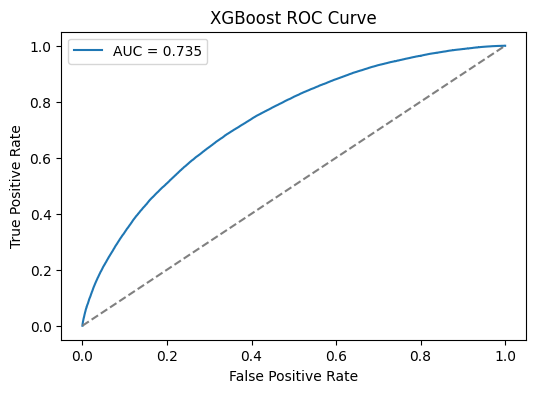

In [15]:
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC Curve")
plt.legend()
plt.show()

## Hyperparameter Tuning

In [16]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split, ParameterGrid

In [17]:
# The dataset is too large to use cross validation with multiple folds to tune hyperparameters
# so let's take a small sample of the data instead
# I originally used a 10% sample but increased it after narrowing down the parameter grid

train_sample = train_df.sample(frac=0.25, random_state=42)
X_sample = train_sample.drop(columns=["target"])
y_sample = train_sample["target"]

In [18]:
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print("scale_pos_weight:", scale_pos_weight)

scale_pos_weight: 4.00936945826565


In [19]:
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_sample, y_sample, test_size=0.2, stratify=y_sample, random_state=42
)

In [20]:
def get_model_scores(model):

    y_proba = model.predict_proba(X_test)[:, 1]

    roc = roc_auc_score(y_test, y_proba).round(4)

    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision).round(4)

    print()
    print(f"Final ROC AUC: {roc} | PR AUC: {pr_auc}")

    return(roc, pr_auc)


def fit_final_model(params, n_estimators, early_stopping_rounds=50):

    final_model = xgb.XGBClassifier(
        n_estimators=n_estimators,
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        subsample=params.get('subsample', 1.0),
        colsample_bytree=1,
        scale_pos_weight=scale_pos_weight,
        early_stopping_rounds=early_stopping_rounds,
        device='cuda',
        eval_metric='auc',
        random_state=42
    )

    final_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=2
    )

    roc, pr_auc = get_model_scores(final_model)

    return final_model, roc, pr_auc


def tune_xg_boost(param_grid, n_estimators, early_stopping_rounds=50):

    best_auc = 0
    best_params = {}

    for params in ParameterGrid(param_grid):
        model = xgb.XGBClassifier(
            n_estimators=n_estimators,
            learning_rate=params['learning_rate'],
            max_depth=params['max_depth'],
            subsample = params['subsample'],
            colsample_bytree = 1,  # Used the param_grid to determine 1 is the best
            scale_pos_weight=scale_pos_weight,
            early_stopping_rounds=early_stopping_rounds,
            device='cuda',
            eval_metric='auc',
            random_state=42
        )

        model.fit(
        X_train_sub, y_train_sub,
        eval_set=[(X_val_sub, y_val_sub)],    
        verbose=False
        )

        y_proba = model.predict_proba(X_val_sub)[:, 1]
        roc = roc_auc_score(y_val_sub, y_proba)

        precision, recall, _ = precision_recall_curve(y_val_sub, y_proba)
        pr_auc = auc(recall, precision)

        if roc > best_auc:
            best_auc = roc
            best_params = params
            best_iteration = model.best_iteration
            best_params_pr_auc = pr_auc
    
    print()
    print("Best params:", best_params, "| Best Iteration:", best_iteration,"| Best Validation AUC:", best_auc.round(4), "| Validation PR AUC:", best_params_pr_auc.round(4))

    final_model, roc, pr_auc = fit_final_model(best_params, n_estimators, early_stopping_rounds)

    return (best_params, final_model, roc, pr_auc)

In [21]:
# Note that I first narrowed down param_grid and I'm now looking more locally.

param_grid_5000 = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.03, 0.05],
    'subsample': [0.75, 0.8, 0.85]
}

best_params_5000, best_model_5000, best_ROC_AUC_5000, best_PR_AUC_5000 = tune_xg_boost(param_grid_5000, 5000, 50)


Best params: {'learning_rate': 0.03, 'max_depth': 3, 'subsample': 0.75} | Best Iteration: 1990 | Best Validation AUC: 0.7295 | Validation PR AUC: 0.3994
[0]	validation_0-auc:0.69098
[2]	validation_0-auc:0.69639
[4]	validation_0-auc:0.69728
[6]	validation_0-auc:0.69883
[8]	validation_0-auc:0.69937
[10]	validation_0-auc:0.69995
[12]	validation_0-auc:0.70028
[14]	validation_0-auc:0.70050
[16]	validation_0-auc:0.70071
[18]	validation_0-auc:0.70119
[20]	validation_0-auc:0.70153
[22]	validation_0-auc:0.70177
[24]	validation_0-auc:0.70209
[26]	validation_0-auc:0.70226
[28]	validation_0-auc:0.70255
[30]	validation_0-auc:0.70271
[32]	validation_0-auc:0.70294
[34]	validation_0-auc:0.70316
[36]	validation_0-auc:0.70336
[38]	validation_0-auc:0.70369
[40]	validation_0-auc:0.70388
[42]	validation_0-auc:0.70414
[44]	validation_0-auc:0.70445
[46]	validation_0-auc:0.70474
[48]	validation_0-auc:0.70518
[50]	validation_0-auc:0.70554
[52]	validation_0-auc:0.70586
[54]	validation_0-auc:0.70622
[56]	valida

In [22]:
# Test similar parameters to see if they are better on the whole dataset.
params = {'learning_rate': 0.04, 'max_depth': 4, 'subsample': 0.7}

fit_final_model(params,n_estimators=5000,early_stopping_rounds=50)

[0]	validation_0-auc:0.69628
[2]	validation_0-auc:0.70156
[4]	validation_0-auc:0.70279
[6]	validation_0-auc:0.70356
[8]	validation_0-auc:0.70395
[10]	validation_0-auc:0.70461
[12]	validation_0-auc:0.70530
[14]	validation_0-auc:0.70558
[16]	validation_0-auc:0.70598
[18]	validation_0-auc:0.70661
[20]	validation_0-auc:0.70690
[22]	validation_0-auc:0.70731
[24]	validation_0-auc:0.70787
[26]	validation_0-auc:0.70819
[28]	validation_0-auc:0.70865
[30]	validation_0-auc:0.70898
[32]	validation_0-auc:0.70931
[34]	validation_0-auc:0.70958
[36]	validation_0-auc:0.70987
[38]	validation_0-auc:0.71030
[40]	validation_0-auc:0.71060
[42]	validation_0-auc:0.71094
[44]	validation_0-auc:0.71126
[46]	validation_0-auc:0.71163
[48]	validation_0-auc:0.71189
[50]	validation_0-auc:0.71228
[52]	validation_0-auc:0.71259
[54]	validation_0-auc:0.71302
[56]	validation_0-auc:0.71336
[58]	validation_0-auc:0.71371
[60]	validation_0-auc:0.71413
[62]	validation_0-auc:0.71450
[64]	validation_0-auc:0.71480
[66]	validation

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
               device='cuda', early_stopping_rounds=50, enable_categorical=False,
               eval_metric='auc', feature_types=None, feature_weights=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.04, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=4, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=5000, n_jobs=None,
               num_parallel_tree=None, ...),
 0.7378,
 0.4151)

We see we can get a PR AUC score of 0.42 to 2.d.p., but our model has lots of trees. Let's try to reduce the number of trees our model has, without losing too much predictive power.

In [23]:
# Note that I first narrowed down param_grid and I'm now looking more locally.

param_grid_500 = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.09, 0.1, 0.11],
    'subsample': [0.85, 0.9, 0.95]
}

best_params_500, best_model_500, best_ROC_AUC_500, best_PR_AUC_500 = tune_xg_boost(param_grid_500, n_estimators=500, early_stopping_rounds=50)


Best params: {'learning_rate': 0.1, 'max_depth': 4, 'subsample': 0.9} | Best Iteration: 374 | Best Validation AUC: 0.7285 | Validation PR AUC: 0.3979
[0]	validation_0-auc:0.69611
[2]	validation_0-auc:0.70258
[4]	validation_0-auc:0.70492
[6]	validation_0-auc:0.70572
[8]	validation_0-auc:0.70666
[10]	validation_0-auc:0.70796
[12]	validation_0-auc:0.70913
[14]	validation_0-auc:0.71003
[16]	validation_0-auc:0.71074
[18]	validation_0-auc:0.71175
[20]	validation_0-auc:0.71260
[22]	validation_0-auc:0.71344
[24]	validation_0-auc:0.71434
[26]	validation_0-auc:0.71519
[28]	validation_0-auc:0.71602
[30]	validation_0-auc:0.71671
[32]	validation_0-auc:0.71729
[34]	validation_0-auc:0.71778
[36]	validation_0-auc:0.71826
[38]	validation_0-auc:0.71876
[40]	validation_0-auc:0.71908
[42]	validation_0-auc:0.71951
[44]	validation_0-auc:0.71989
[46]	validation_0-auc:0.72023
[48]	validation_0-auc:0.72050
[50]	validation_0-auc:0.72082
[52]	validation_0-auc:0.72109
[54]	validation_0-auc:0.72134
[56]	validatio

We can see that we are able to significantly reduce the number of trees without losing much predictive power. Let's also try 1000 trees and then we will stop.

In [24]:
# Note that I first narrowed down param_grid and I'm now looking more locally.

param_grid_1000 = {
    'max_depth': [2, 3, 4],
    'learning_rate': [0.09, 0.1, 0.11],
    'subsample': [0.9, 0.95, 1]
}

best_params_1000, best_model_1000, best_ROC_AUC_1000, best_PR_AUC_1000 = tune_xg_boost(param_grid_1000, n_estimators=1000, early_stopping_rounds=50)


Best params: {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.95} | Best Iteration: 649 | Best Validation AUC: 0.7289 | Validation PR AUC: 0.3985
[0]	validation_0-auc:0.69116
[2]	validation_0-auc:0.69876
[4]	validation_0-auc:0.70079
[6]	validation_0-auc:0.70170
[8]	validation_0-auc:0.70247
[10]	validation_0-auc:0.70323
[12]	validation_0-auc:0.70424
[14]	validation_0-auc:0.70531
[16]	validation_0-auc:0.70649
[18]	validation_0-auc:0.70770
[20]	validation_0-auc:0.70861
[22]	validation_0-auc:0.70975
[24]	validation_0-auc:0.71076
[26]	validation_0-auc:0.71171
[28]	validation_0-auc:0.71236
[30]	validation_0-auc:0.71320
[32]	validation_0-auc:0.71398
[34]	validation_0-auc:0.71468
[36]	validation_0-auc:0.71519
[38]	validation_0-auc:0.71578
[40]	validation_0-auc:0.71632
[42]	validation_0-auc:0.71664
[44]	validation_0-auc:0.71707
[46]	validation_0-auc:0.71743
[48]	validation_0-auc:0.71773
[50]	validation_0-auc:0.71807
[52]	validation_0-auc:0.71839
[54]	validation_0-auc:0.71865
[56]	validati

In [25]:
cost_fns = [5, 10, 20]
threshold_dict = calc_optimal_thresholds(cost_fns, best_model_500)
calc_classification_reports(threshold_dict, best_model_500)

Best threshold: 0.45
Min expected cost: 156295

Best threshold: 0.3
Min expected cost: 188012

Best threshold: 0.18
Min expected cost: 206099

Classification report for cost: 5

              precision    recall  f1-score   support

           0       0.91      0.57      0.70    215350
           1       0.31      0.76      0.44     53712

    accuracy                           0.61    269062
   macro avg       0.61      0.67      0.57    269062
weighted avg       0.79      0.61      0.65    269062


Classification report for cost: 10

              precision    recall  f1-score   support

           0       0.94      0.31      0.47    215350
           1       0.25      0.93      0.39     53712

    accuracy                           0.43    269062
   macro avg       0.60      0.62      0.43    269062
weighted avg       0.81      0.43      0.45    269062


Classification report for cost: 20

              precision    recall  f1-score   support

           0       0.97      0.12      

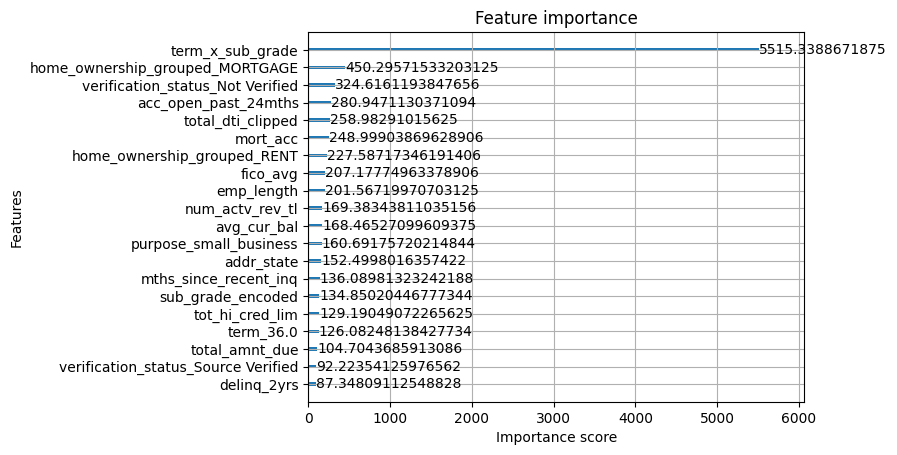

In [26]:
xgb.plot_importance(best_model_500, importance_type='gain', max_num_features=20)
plt.show()

# Conclusion

In [35]:
df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

In [40]:
df['default_prob'] = best_model_500.predict_proba(df.drop(['target'], axis=1))[:,1]

In [41]:
df_sorted = df.sort_values('default_prob', ascending=False).reset_index(drop=True)
df_sorted.head()

,addr_state,loan_amnt,int_rate,installment,emp_length,annual_inc,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,purpose_vacation,purpose_wedding,application_type_Individual,application_type_Joint App,home_ownership_grouped_MORTGAGE,home_ownership_grouped_OWN,home_ownership_grouped_Other,home_ownership_grouped_RENT,target,default_prob
0,1.921848,28000.0,25.65,832.55,2.0,118000.0,3.0,2.0,20.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,0.971317
1,0.987515,35000.0,30.75,1500.22,5.0,88992.0,0.0,3.0,3.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1,0.962173
2,-0.093634,26600.0,24.99,780.59,10.0,70000.0,2.0,2.0,11.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1,0.959235
3,0.151090,16000.0,26.77,486.37,0.0,32000.0,0.0,3.0,8.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1,0.957229
4,-0.128610,32000.0,30.99,1054.86,2.0,75960.0,0.0,1.0,16.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,0.956782


In [93]:
def calc_optimal_cutoff(df, steps=200):
    # Sort by predicted default probability
    df = df.sort_values('default_prob', ascending=False).reset_index(drop=True)

    df['term_months'] = 36 * df['term_36.0'] + 60 * df['term_60.0']
    df['profit_if_paid'] = (df['installment'] * df['term_months']) - df['loan_amnt']

    best_cutoff = None
    best_threshold = None
    max_net_gain = float('-inf')
    results = []

    for frac in np.linspace(0.01, 0.5, steps):  # Try from 1% to 50%
        cutoff_index = int(len(df) * frac)

        rejected = df.iloc[:cutoff_index]
        
        # Given the most common loan purposes are debt consolidation and credit cards, we will assume an average recovery rate of 10% on defaulted loans
        saved_amount = rejected.loc[rejected['target'] == 1, 'loan_amnt'].sum() * 0.9
        lost_opportunity = rejected.loc[rejected['target'] == 0, 'profit_if_paid'].sum()
        net_gain = saved_amount - lost_opportunity

        # Find the default probability threshold at this cutoff
        prob_threshold = df.iloc[cutoff_index - 1]['default_prob'] if cutoff_index > 0 else 1.0

        results.append({
            'cutoff_percent': frac,
            'saved_amount': saved_amount,
            'lost_opportunity': lost_opportunity,
            'net_gain': net_gain,
            'prob_threshold': prob_threshold
        })

        if net_gain > max_net_gain:
            max_net_gain = net_gain
            best_cutoff = frac
            best_threshold = prob_threshold
            
    results_df = pd.DataFrame(results)

    return best_cutoff, results_df

In [94]:
best_cutoff, results_df = calc_optimal_cutoff(df)

In [95]:
print(best_cutoff)
print(results_df.sort_values(by='net_gain',ascending=False).head(10))

0.22175879396984927
    cutoff_percent  saved_amount  lost_opportunity      net_gain  \
86        0.221759  1.964291e+09      1.407289e+09  5.570019e+08   
81        0.209447  1.896054e+09      1.339270e+09  5.567845e+08   
85        0.219296  1.950660e+09      1.393903e+09  5.567574e+08   
84        0.216834  1.937189e+09      1.380568e+09  5.566211e+08   
80        0.206985  1.882048e+09      1.325473e+09  5.565749e+08   
83        0.214372  1.923372e+09      1.366818e+09  5.565541e+08   
78        0.202060  1.854112e+09      1.297601e+09  5.565107e+08   
82        0.211910  1.909653e+09      1.353164e+09  5.564885e+08   
79        0.204523  1.868033e+09      1.311663e+09  5.563709e+08   
87        0.224221  1.977158e+09      1.420794e+09  5.563633e+08   

    prob_threshold  
86        0.619986  
81        0.628660  
85        0.621704  
84        0.623448  
80        0.630420  
83        0.625172  
78        0.633893  
82        0.626925  
79        0.632156  
87        0.618244  


Our model shows that, given our assumptions of a 10% recovery rate, we could cut ~22% of the riskiest loans and that would result in an optimal net gain of $557m. This does not account for more complex assumptions such as the time value of money, opportunity cost, etc.